In [26]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import duckdb
import scipy.stats as stats
import time
import matplotlib.dates as mdates

sns.set(style="whitegrid")

In [27]:
print(duckdb.__version__)

0.5.1


# Information

We want to investigate the reviews to price of airbnbs. For reviews we have many different factors that a guest can rate a host on. There is the overall review score and other sub-scores. The assumption is that a higher review score means the host can charge a higher price.

## Data

The variables we are interested in from the all listings table are reviews.
* review_scores_rating
* review_scores_accuracy
* review_scores_cleanliness
* review_scores_checkin
* review_scores_communication
* review_scores_location
* review_scores_value
* number_of_reviews
* number_of_reviews_ltm
* number_of_reviews_l30d
* reviews_per_month

In [28]:
con = duckdb.connect(database='ps6.duckdb', read_only=False)

In [33]:
all_listings = con.execute('SELECT * from all_listings').df()

In [34]:
all_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28076 entries, 0 to 28075
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            28076 non-null  int64         
 1   listing_url                                   28076 non-null  object        
 2   scrape_id                                     28076 non-null  int64         
 3   last_scraped                                  28076 non-null  datetime64[ns]
 4   name                                          28074 non-null  object        
 5   description                                   27666 non-null  object        
 6   neighborhood_overview                         18547 non-null  object        
 7   picture_url                                   28076 non-null  object        
 8   host_id                                       28076 non-null  int3

In [35]:
all_listings.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3686,https://www.airbnb.com/rooms/3686,20220914194735,2022-09-14,Vita's Hideaway,IMPORTANT NOTES<br />* Carefully read and be s...,We love that our neighborhood is up and coming...,https://a0.muscache.com/pictures/61e02c7e-3d66...,4645,https://www.airbnb.com/users/show/4645,...,4.83,3.86,4.62,NaN,False,1,0,1,0,0.56
1,841260,https://www.airbnb.com/rooms/841260,20220914194735,2022-09-15,Metro Style Living in Washington DC,Metro Style Living in Washington DC<br /><br /...,Its a very safe neighborhood and the house is ...,https://a0.muscache.com/pictures/4261fe6f-4828...,315148,https://www.airbnb.com/users/show/315148,...,4.86,4.57,4.29,NaN,False,46,0,46,0,0.12
2,3943,https://www.airbnb.com/rooms/3943,20220914194735,2022-09-15,Historic Rowhouse Near Monuments,You will be enjoying the en-suite style space ...,This rowhouse is centrally located in the hear...,https://a0.muscache.com/pictures/6d12fcf6-1f03...,5059,https://www.airbnb.com/users/show/5059,...,4.90,4.55,4.74,Hosted License: 5007242201001033,False,4,0,4,0,2.73
3,842418,https://www.airbnb.com/rooms/842418,20220914194735,2022-09-14,Luxury Penthouse in the heart of DC!,Please DO NOT send a reservation request witho...,-2 blocks from Penn Quarter/Gallery Place rest...,https://a0.muscache.com/pictures/a827f2fc-53c7...,2236092,https://www.airbnb.com/users/show/2236092,...,4.66,4.96,4.67,NaN,False,1,1,0,0,0.59
4,860336,https://www.airbnb.com/rooms/860336,20220914194735,2022-09-14,Luxury Spacious Master Suite RoofDeck in DuPont,HOSTING FULLY VACCINATED GUESTS ONLY! (all gu...,NaN,https://a0.muscache.com/pictures/12674471/9510...,511136,https://www.airbnb.com/users/show/511136,...,4.87,4.94,4.70,Hosted License: 5007242201000569,False,4,1,3,0,3.99


# EDA

## Single Variable EDA

We'll start our EDA by looking at each variable individually, starting with the target variable, price.

## Price

Prices are the main variable of interest and represent daily price charged for that listing in the database. We would expect for there to be a lot of smaller charges and a few very large charges. The data is probably skewed right since airbnb is meant to compete with hotels in an area and usually the prices per night are less than $100 on the platform.

In [37]:
all_listings.price.describe()

count    28076.000000
mean       188.662594
std        384.123697
min          0.000000
25%         85.000000
50%        125.000000
75%        200.000000
max      24999.000000
Name: price, dtype: float64

The price variable shows the mean is `$188.66` per night with a std of `$384`. It is very likely the data is skewed or being impacted by very large outliers. The min is 0.00, which is likely from listings that are not available.  The median is `$125` and the 3rd-quartile is `$200`. The max is `$24999`! that is really high, I wonder how many of those values are in the data. Let's plot a histogram of the data using 50 bins, because of the outliers we need to account for such a massive difference.

It looks like we need to set the range because all an vast majority of our values are below `$2000`. I'm going to check how many are above `$1000` and see if setting that as the max will help. 

In [39]:
print(all_listings[all_listings["price"] > 1000 ]["price"])

86       3500.0
390      1141.0
570      1128.0
633      1586.0
810      5995.0
          ...  
26933    1119.0
27057    4357.0
27240    1250.0
27458    1925.0
27686    5000.0
Name: price, Length: 311, dtype: float64


About 1% of our listings are above $1000 per night. I'm going to plot them within that range to remove the 99th  percentile of the data.

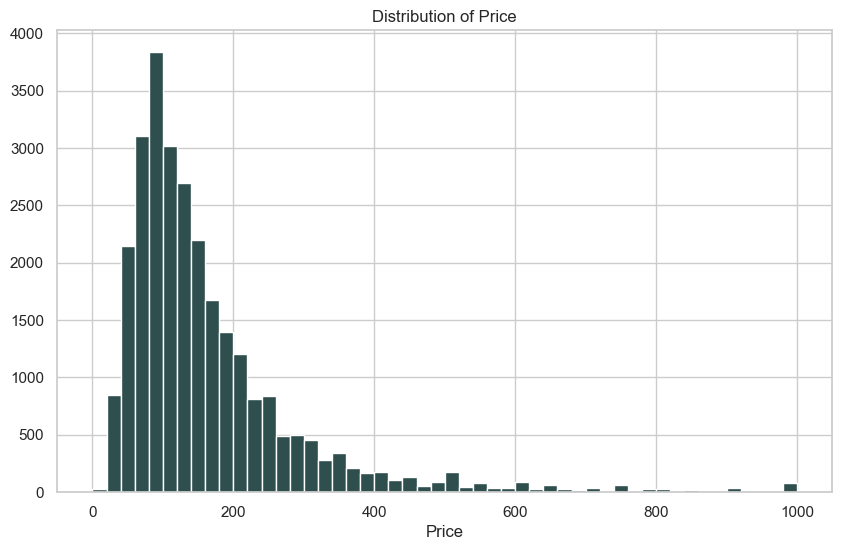

In [40]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(all_listings.price,range=[0,1000], bins=50, color="darkslategray")
axes.set_title("Distribution of Price")
axes.set_xlabel("Price")

plt.show()
plt.close()

Most of the prices are between 0-300 per night.

## review_scores_rating

The data dictionary does not list the details on this variable. We'll have to explore what it might be and figure it our from there.

In [42]:
all_listings.review_scores_rating.describe()

count    21844.000000
mean         4.703923
std          0.588795
min          0.000000
25%          4.670000
50%          4.850000
75%          4.970000
max          5.000000
Name: review_scores_rating, dtype: float64

There are 21844 review score listings so some of our listings don't have a review score listed. That is interesting. We may have to cull those null rows from our data to match the sizes of price and review scores. Most of the reviews are 4s with a few differences .588 std.

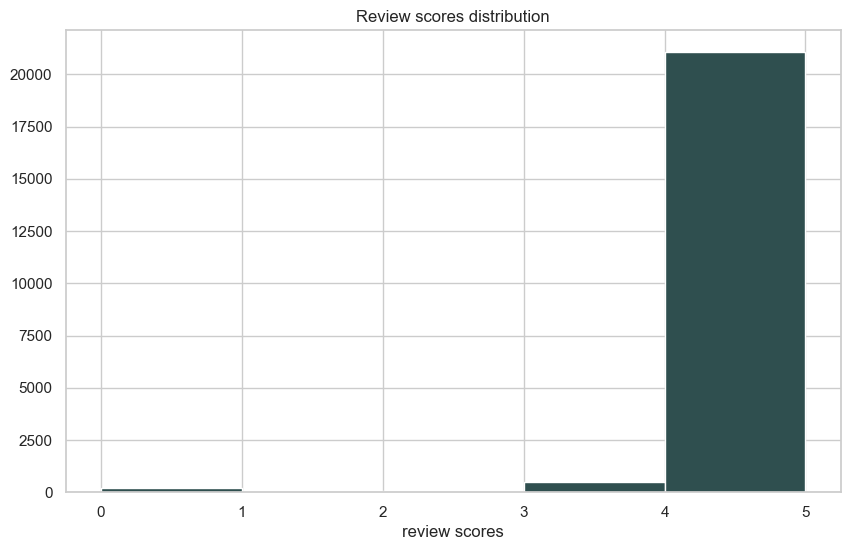

In [48]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(all_listings.review_scores_rating,bins=5, color="darkslategray")
axes.set_title("Review scores distribution")
axes.set_xlabel("review scores")

plt.show()
plt.close()

We have a few zeros but mostly 4's and 5's. Not all that interesting. 

## review_scores_accuracy

There is no entry for this in the data dictionary but I think it is basically the review score that measures how accurate the description of the listing was to the actual property that the guest was staying in. This is actually fairly important because it alerts someone if you are being shown fake images of a listing that is actually not the same as the one you are staying in.

In [49]:
all_listings.review_scores_accuracy.describe()

count    21649.000000
mean         4.806455
std          0.369802
min          0.000000
25%          4.780000
50%          4.910000
75%          5.000000
max          5.000000
Name: review_scores_accuracy, dtype: float64

First thing I notice is the number of reviews is different for this one as well with only 21649 compared to 28000+ listings. It's also lower than our previous variable scores_rating. It's basically the same distribution of scores, mostly high 4s and 5s. 

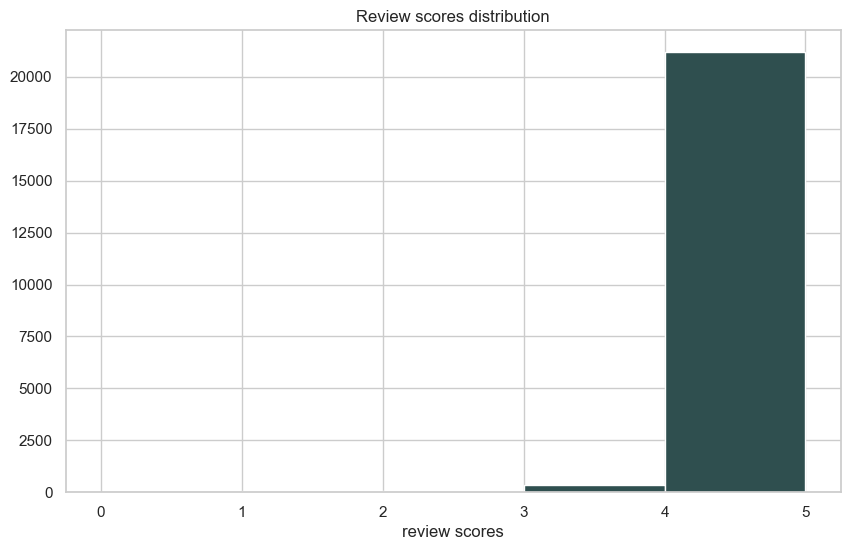

In [50]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(all_listings.review_scores_accuracy,bins=5, color="darkslategray")
axes.set_title("Review scores distribution")
axes.set_xlabel("review scores")

plt.show()
plt.close()

## review_scores_cleanliness

There is no entry for this in the data dictionary but I think it is basically the review score that measures how clean the property was when the guest stayed there.

In [51]:
all_listings.review_scores_cleanliness.describe()

count    21651.000000
mean         4.751469
std          0.391304
min          0.000000
25%          4.680000
50%          4.880000
75%          5.000000
max          5.000000
Name: review_scores_cleanliness, dtype: float64

Again there is a different number of total reviews than the other review variables and total. It's basically the same distribution of scores, mostly high 4s and 5s.

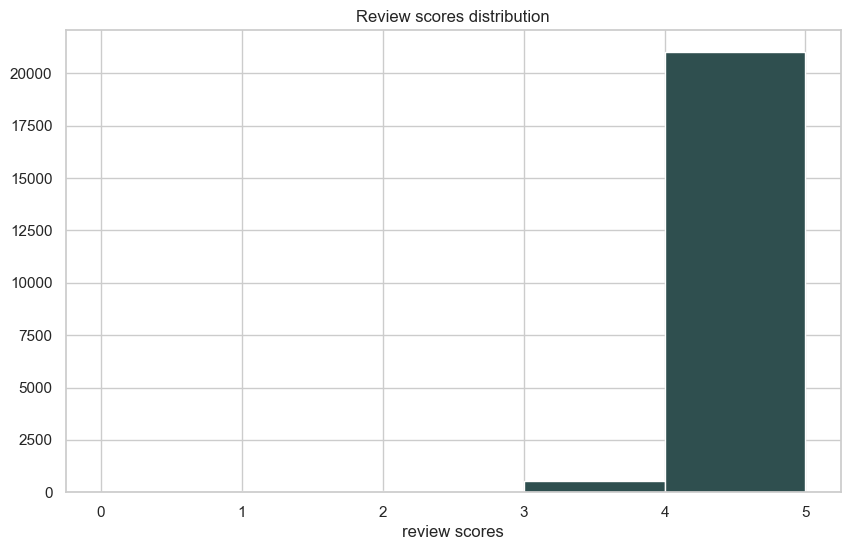

In [52]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(all_listings.review_scores_cleanliness,bins=5, color="darkslategray")
axes.set_title("Review scores distribution")
axes.set_xlabel("review scores")

plt.show()
plt.close()

## review_scores_checkin

There is no entry for this in the data dictionary but I think it is basically the review score that measures how easy and simple the check in process was for the property.

In [53]:
all_listings.review_scores_checkin.describe()

count    21645.000000
mean         4.863341
std          0.329336
min          0.000000
25%          4.870000
50%          4.960000
75%          5.000000
max          5.000000
Name: review_scores_checkin, dtype: float64

Again there is a different number of total reviews than the other review variables and total. It's basically the same distribution of scores, mostly high 4s and 5s.

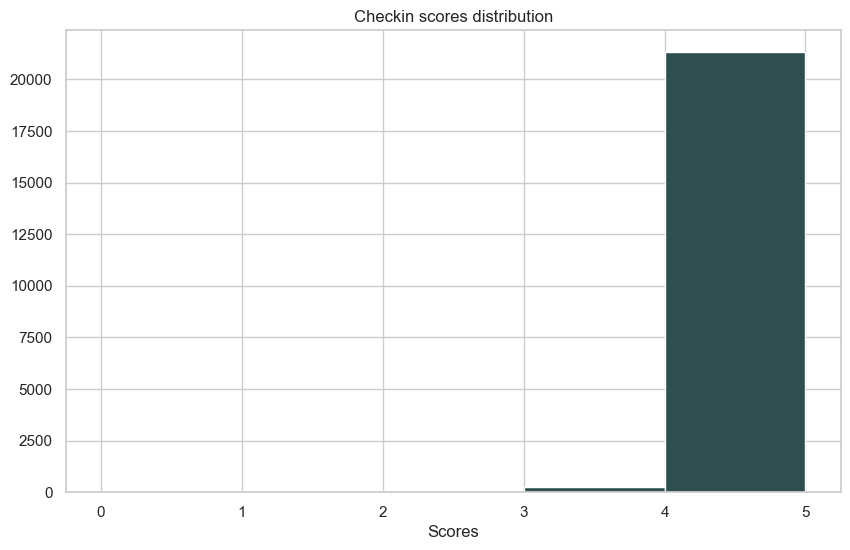

In [62]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(all_listings.review_scores_checkin,bins=5, color="darkslategray")
axes.set_title("Checkin scores distribution")
axes.set_xlabel("Scores")

plt.show()
plt.close()

## review_scores_communication

There is no entry for this in the data dictionary but I think it is basically the review score that measures how communicative the host was during the whole stay, from responding to questions pre-checkin and any thing else during the stay at the property.

In [55]:
all_listings.review_scores_communication.describe()

count    21651.000000
mean         4.849109
std          0.352642
min          0.000000
25%          4.850000
50%          4.960000
75%          5.000000
max          5.000000
Name: review_scores_communication, dtype: float64

Again there is a different number of total reviews, but this one matches with the number who left a review for cleaning. It's basically the same distribution of scores, mostly high 4s and 5s.

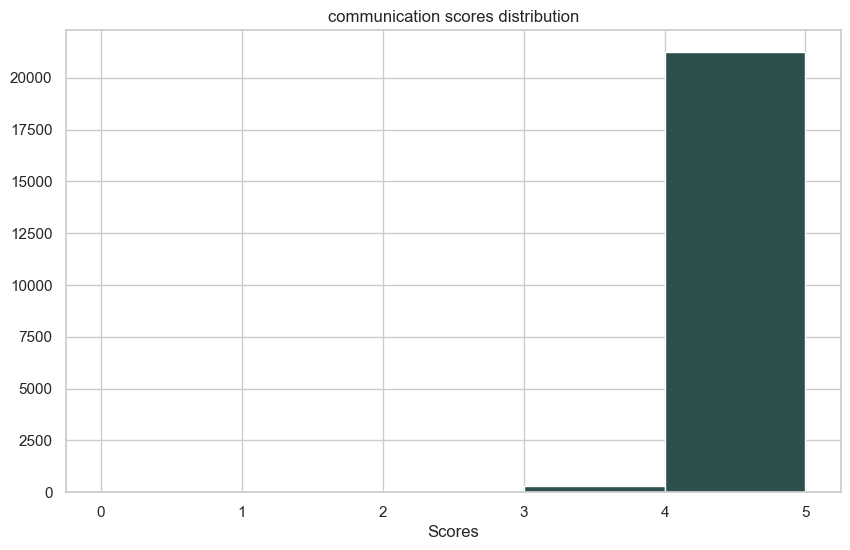

In [61]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(all_listings.review_scores_communication,bins=5, color="darkslategray")
axes.set_title("communication scores distribution")
axes.set_xlabel("Scores")

plt.show()
plt.close()

## review_scores_location

There is no entry for this in the data dictionary but I think it is basically the review score that measures the location and neighborhood the listing is in. This could be useful for our crime data comparison. 

In [57]:
all_listings.review_scores_location.describe()

count    21646.000000
mean         4.795683
std          0.346069
min          0.000000
25%          4.740000
50%          4.910000
75%          5.000000
max          5.000000
Name: review_scores_location, dtype: float64

There is a different number of total reviews than the other review variables and total. It's basically the same distribution of scores, mostly high 4s and 5s.

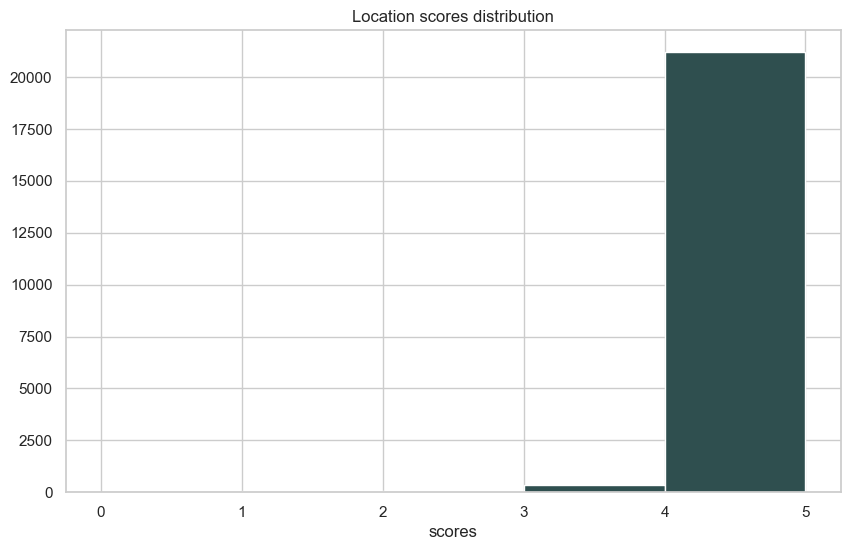

In [60]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(all_listings.review_scores_location,bins=5, color="darkslategray")
axes.set_title("Location scores distribution")
axes.set_xlabel("scores")

plt.show()
plt.close()

## review_scores_value

There is no entry for this in the data dictionary but I think it is basically the review score that measures the "bang for you buck" metric. Such as how affordable the space was, did the price per night match up well with the amenities and other things offered by the host.

In [63]:
all_listings.review_scores_value.describe()

count    21641.000000
mean         4.710893
std          0.408097
min          0.000000
25%          4.650000
50%          4.810000
75%          4.920000
max          5.000000
Name: review_scores_value, dtype: float64

There is a different number of total reviews than the other review variables and total. It's basically the same distribution of scores, mostly high 4s and 5s.

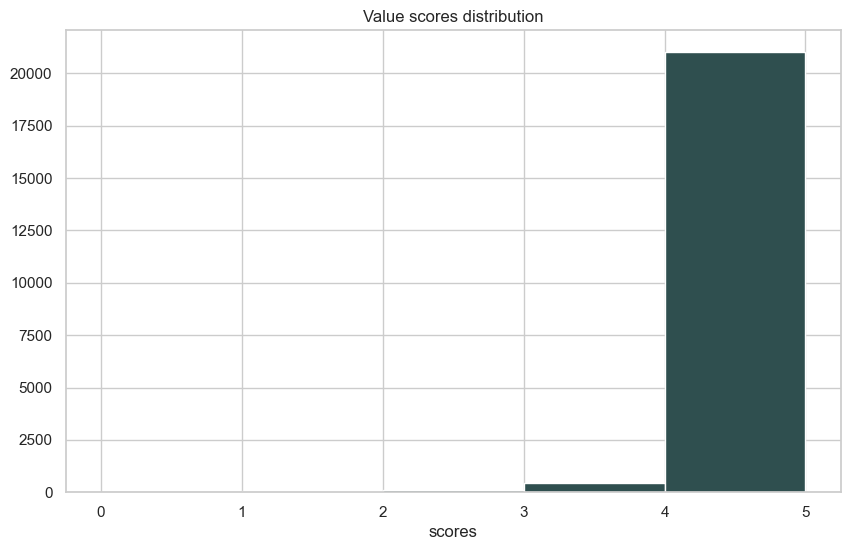

In [64]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(all_listings.review_scores_value,bins=5, color="darkslategray")
axes.set_title("Value scores distribution")
axes.set_xlabel("scores")

plt.show()
plt.close()

## number_of_reviews

The number of reviews the listing has.

In [66]:
all_listings.number_of_reviews.describe()

count    28076.000000
mean        44.390511
std         78.659086
min          0.000000
25%          1.000000
50%         10.000000
75%         52.000000
max        875.000000
Name: number_of_reviews, dtype: float64

The mean is 44 reviews per listing with an std of 77, this is very skewed. It likely means there are a lot of properties that have been on airbnb for a long time, additionally, not many people leave reviews, I think the data estimates less than 30% leave a review after their stay. That would account for 1/4th having only 1 review and the median being 10 reviews. 

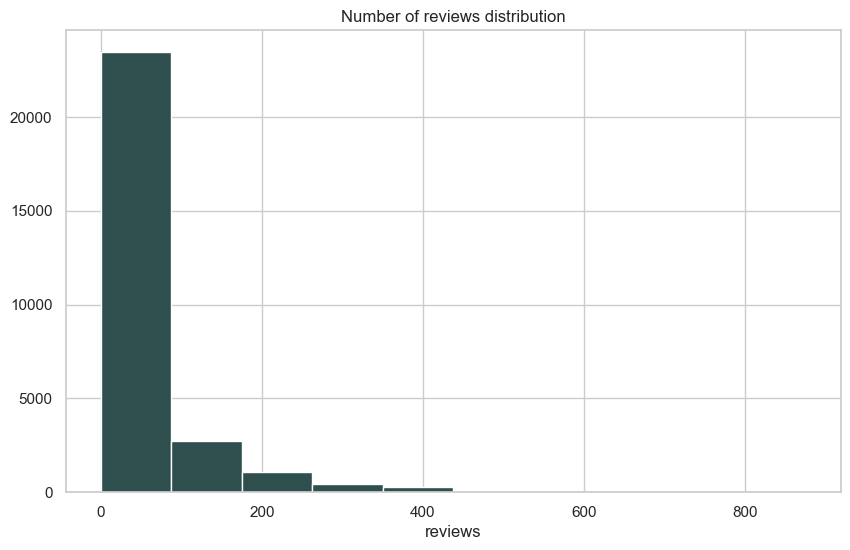

In [69]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(all_listings.number_of_reviews,bins=10, color="darkslategray")
axes.set_title("Number of reviews distribution")
axes.set_xlabel("reviews")

plt.show()
plt.close()

Let's look at just a range between 0-20 total reviews. 

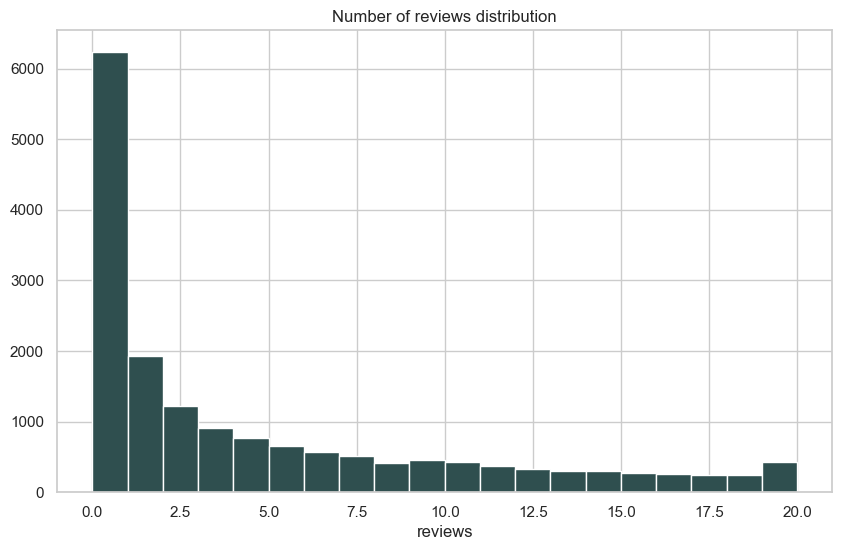

In [72]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(all_listings.number_of_reviews,range=[0,20],bins=20, color="darkslategray")
axes.set_title("Number of reviews distribution")
axes.set_xlabel("reviews")

plt.show()
plt.close()

This is interesting, it looks like a large number of properties have less than 2 total reviews. That's going to skew our data considerably. Let's see how many are zero reviews. 

In [75]:
print(all_listings[all_listings["number_of_reviews"] == 0 ]["number_of_reviews"])

46       0
61       0
82       0
114      0
155      0
        ..
28069    0
28070    0
28071    0
28072    0
28075    0
Name: number_of_reviews, Length: 6232, dtype: int32


It seems that 22% of our listings have 0 reviews! That's very high.

## number_of_reviews_ltm

The number of reviews the listing has (in the last 12 months). I'm hoping this matches our four quarters as measured. 

In [81]:
all_listings.number_of_reviews_ltm.describe()

count    28076.000000
mean        11.183573
std         19.268638
min          0.000000
25%          0.000000
50%          2.000000
75%         15.000000
max        341.000000
Name: number_of_reviews_ltm, dtype: float64

In the last 12 months, there were a mean number of 11 reviews for our listings. The median is 2 and the 3rd quartile is 15. There is a min of 0 reviews and a max of 341 reviews, that's almost one review per day for that listing!

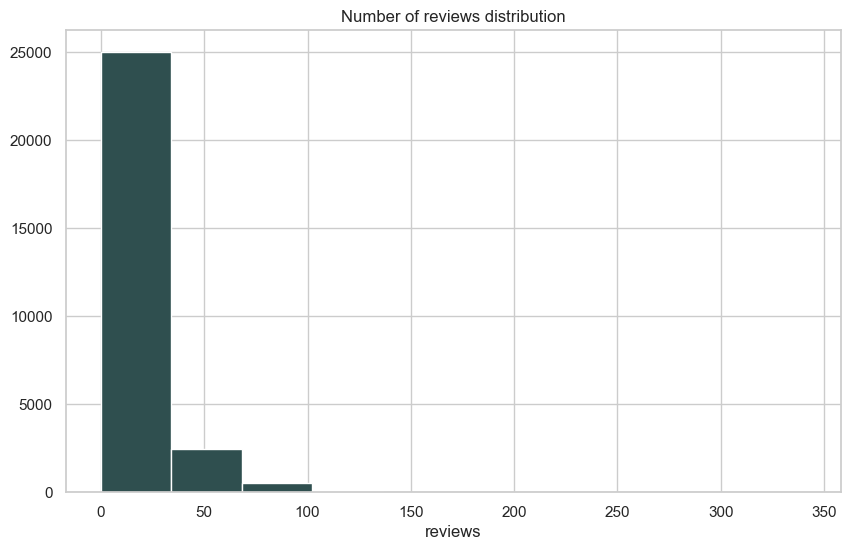

In [82]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(all_listings.number_of_reviews_ltm,bins=10, color="darkslategray")
axes.set_title("Number of reviews distribution")
axes.set_xlabel("reviews")

plt.show()
plt.close()

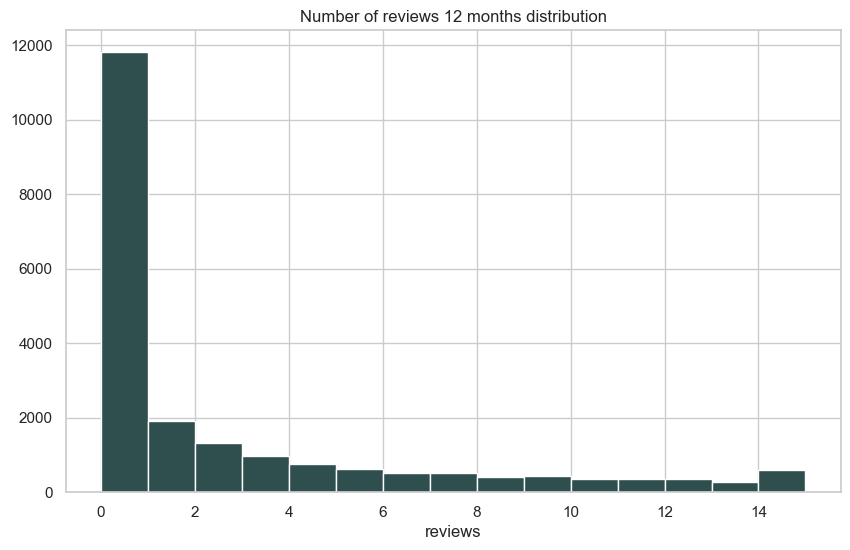

In [83]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(all_listings.number_of_reviews_ltm,range=[0,15],bins=15, color="darkslategray")
axes.set_title("Number of reviews 12 months distribution")
axes.set_xlabel("reviews")

plt.show()
plt.close()

## number_of_reviews_l30d

This variable is the number of reviews the listing has (in the last 30 days).

In [84]:
all_listings.number_of_reviews_l30d.describe()

count    28076.000000
mean         0.960963
std          2.019189
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        119.000000
Name: number_of_reviews_l30d, dtype: float64

In the last 30 months, there were a mean number of less than 1 reviews for our listings. The median is 0 and the 3rd quartile is 1. There is a min of 0 reviews and a max of 119 reviews.

# reviews_per_month

The number of reviews the listing has over the lifetime of the listing.

In [86]:
all_listings.reviews_per_month.describe()

count    21844.000000
mean         1.654230
std          1.995935
min          0.010000
25%          0.270000
50%          1.000000
75%          2.430000
max        105.000000
Name: reviews_per_month, dtype: float64

In our listings there were a mean number of less than 1 reviews for the lifetime of listings. The median is 0 and the 3rd quartile is 2. There is a min of 0 reviews and a max of 105 reviews.

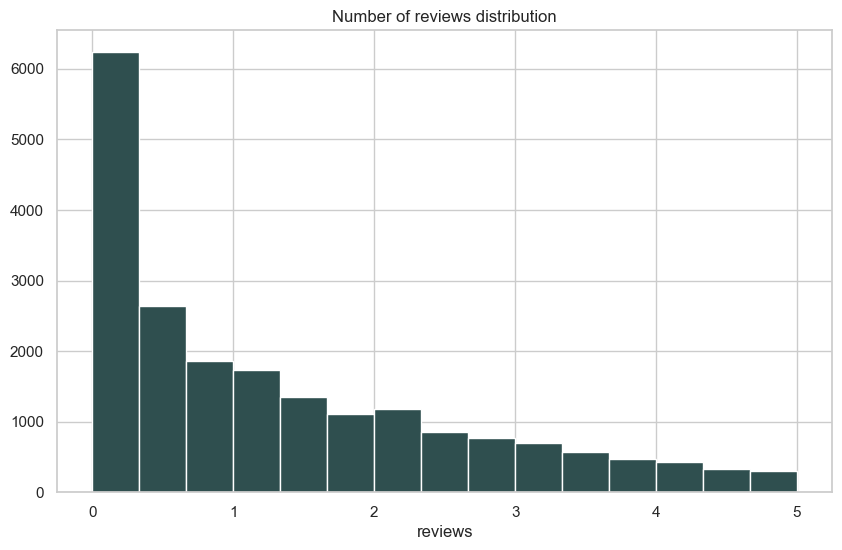

In [88]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(all_listings.reviews_per_month,range=[0,5],bins=15, color="darkslategray")
axes.set_title("Number of reviews distribution")
axes.set_xlabel("reviews")

plt.show()
plt.close()

## Price v. review_scores_rating

The price comparison with review scores. Let's look at the correlation coefficient. 

In [91]:
all_listings_review_scores_clean = all_listings.review_scores_rating.fillna(0)

In [93]:
print("r   = ", stats.pearsonr(all_listings.price, all_listings_review_scores_clean)[0])
print("rho = ", stats.spearmanr(all_listings.price, all_listings_review_scores_clean)[0])

r   =  -0.12359968450965886
rho =  -0.06881169337918605


Pearson's correlation coefficient, $r$, is only -0.12 which indicates a weak inverse relationship. Spearman's is interesting at -0.06 which might indicate that at least a weak inverse monotonic relationship. This is interesting because if means that as scores go up price goes down. I'm not sure why that would be the case.

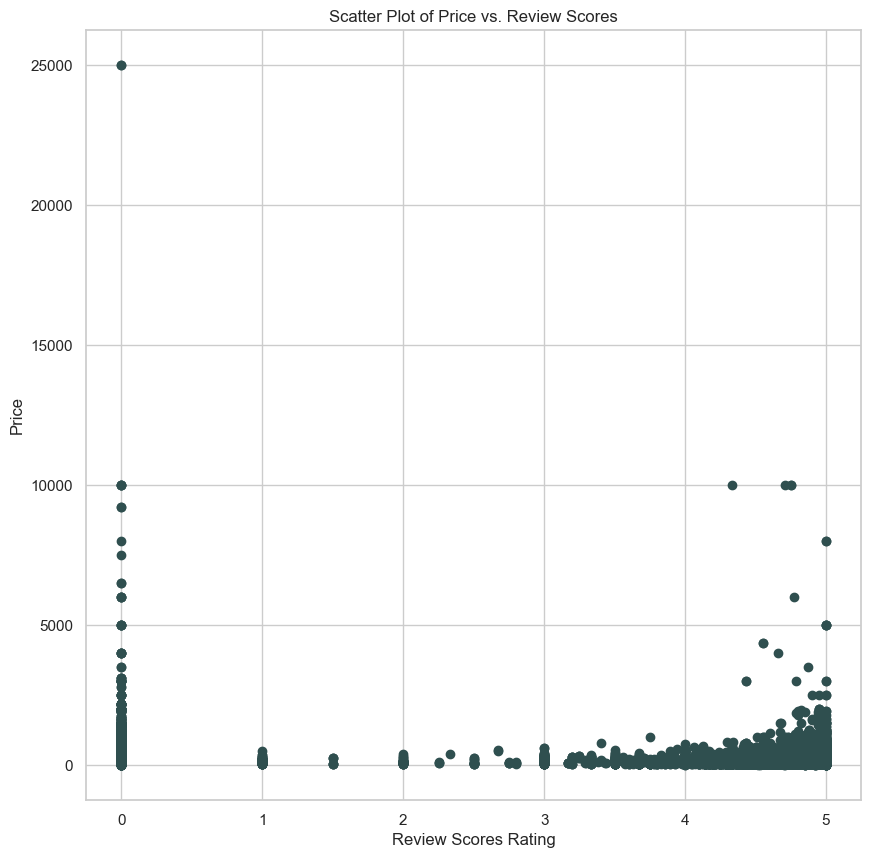

In [95]:
figure = plt.figure(figsize=(10, 10))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(all_listings_review_scores_clean, all_listings.price, marker="o", color="darkslategray")

axes.set_ylabel("Price")
axes.set_xlabel("Review Scores Rating")
axes.set_title("Scatter Plot of Price vs. Review Scores")

plt.show()
plt.close()

## Price v. review_scores_accuracy

The price comparison with review scores accuracy. Let's look at the correlation coefficient. 

In [96]:
all_listings_review_scores_accuracy = all_listings.review_scores_accuracy.fillna(0)

In [97]:
print("r   = ", stats.pearsonr(all_listings.price, all_listings_review_scores_accuracy)[0])
print("rho = ", stats.spearmanr(all_listings.price, all_listings_review_scores_accuracy)[0])

r   =  -0.12721006874052798
rho =  -0.09345451114843224


Pearson's correlation coefficient,  𝑟 , is only -0.12 which indicates a weak inverse relationship. Spearman's is interesting at -0.09 which might indicate that at least a weak inverse monotonic relationship. This is interesting because if means that as scores go up price goes down. I'm not sure why that would be the case.

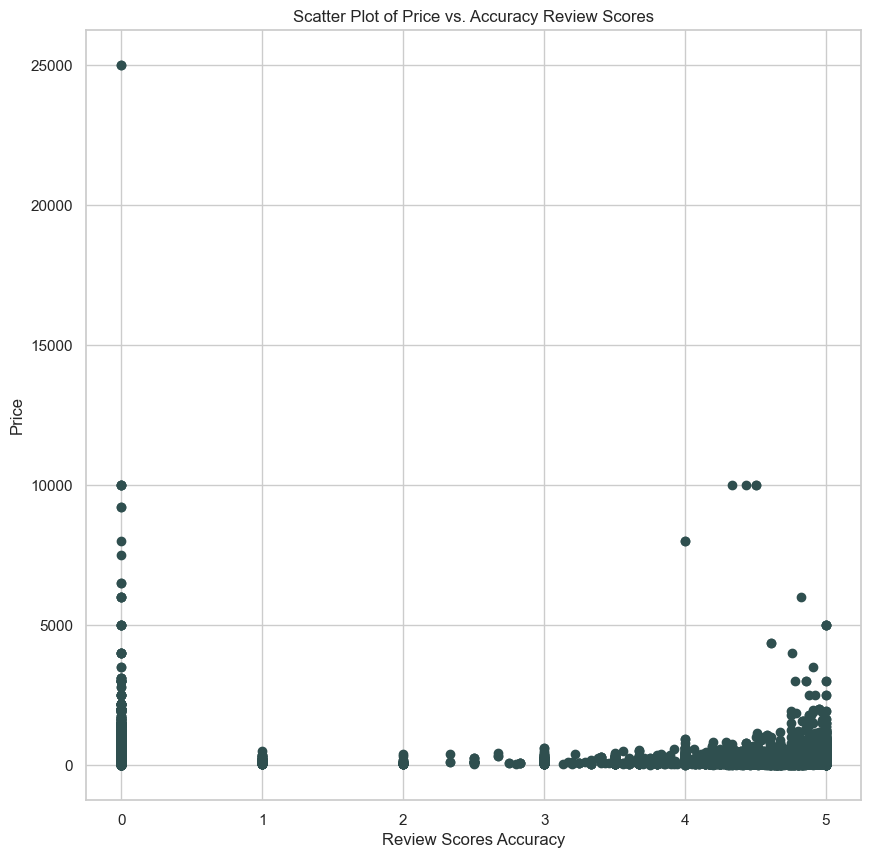

In [98]:
figure = plt.figure(figsize=(10, 10))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(all_listings_review_scores_accuracy, all_listings.price, marker="o", color="darkslategray")

axes.set_ylabel("Price")
axes.set_xlabel("Review Scores Accuracy")
axes.set_title("Scatter Plot of Price vs. Accuracy Review Scores")

plt.show()
plt.close()

## review_scores_cleanliness

The price comparison with review scores cleanliness. Let's look at the correlation coefficient.

In [99]:
all_listings_review_scores_cleanliness = all_listings.review_scores_cleanliness.fillna(0)

In [100]:
print("r   = ", stats.pearsonr(all_listings.price, all_listings_review_scores_cleanliness)[0])
print("rho = ", stats.spearmanr(all_listings.price, all_listings_review_scores_cleanliness)[0])

r   =  -0.12419482772764033
rho =  -0.06033457179164735


Pearson's correlation coefficient, 𝑟 , is only -0.12 which indicates a weak inverse relationship. Spearman's is interesting at -0.06 which might indicate that at least a weak inverse monotonic relationship. This is interesting because if means that as scores go up price goes down. I'm not sure why that would be the case.

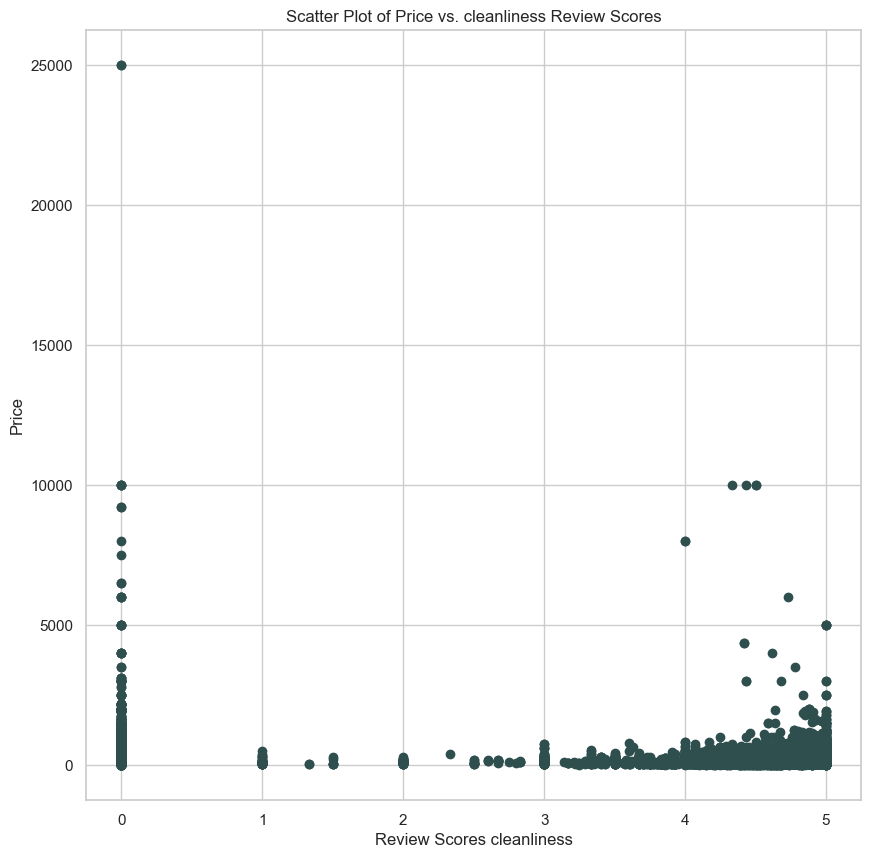

In [101]:
figure = plt.figure(figsize=(10, 10))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(all_listings_review_scores_cleanliness, all_listings.price, marker="o", color="darkslategray")

axes.set_ylabel("Price")
axes.set_xlabel("Review Scores cleanliness")
axes.set_title("Scatter Plot of Price vs. cleanliness Review Scores")

plt.show()
plt.close()

These are all very similar graphics due to the way the ratings are all very similar as we saw from EDA. 

## Price v. review_scores_checkin

In [102]:
all_listings_review_scores_checkin = all_listings.review_scores_checkin.fillna(0)

In [103]:
print("r   = ", stats.pearsonr(all_listings.price, all_listings_review_scores_checkin)[0])
print("rho = ", stats.spearmanr(all_listings.price, all_listings_review_scores_checkin)[0])

r   =  -0.12645822923551384
rho =  -0.1025115497788305


Pearson's correlation coefficient, 𝑟 , is only -0.12 which indicates a weak inverse relationship. Spearman's is interesting at -0.10 which might indicate that at least a weak inverse monotonic relationship. This is interesting because if means that as scores go up price goes down. I'm not sure why that would be the case.

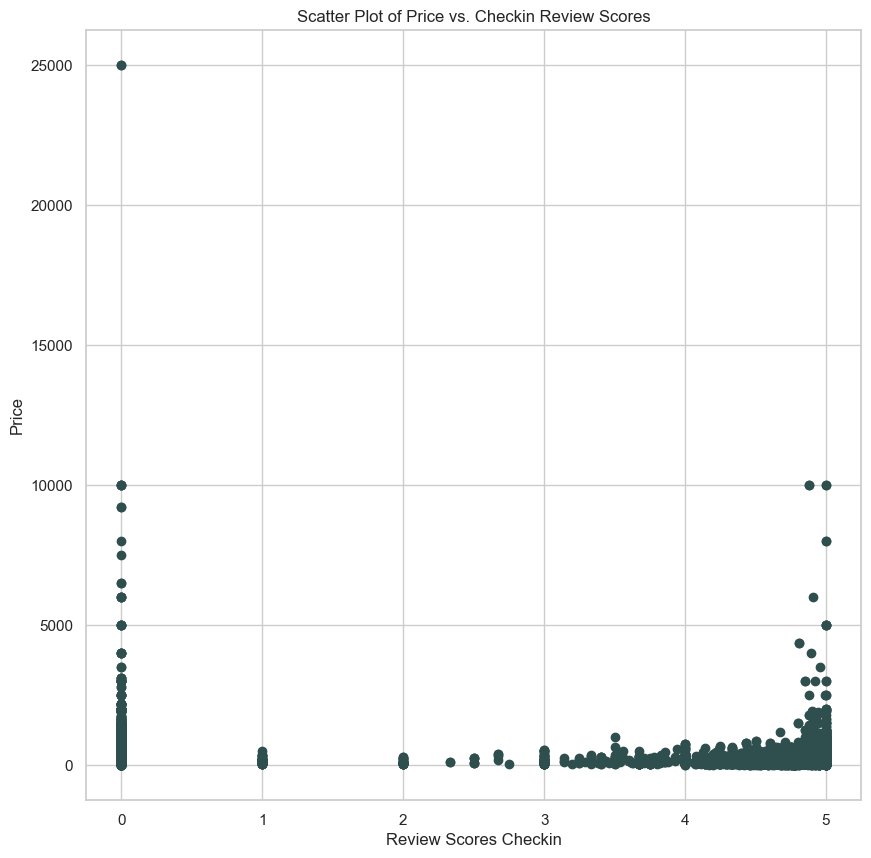

In [104]:
figure = plt.figure(figsize=(10, 10))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(all_listings_review_scores_checkin, all_listings.price, marker="o", color="darkslategray")

axes.set_ylabel("Price")
axes.set_xlabel("Review Scores Checkin")
axes.set_title("Scatter Plot of Price vs. Checkin Review Scores")

plt.show()
plt.close()

## Price v. review_scores_communication

In [105]:
all_listings_review_scores_communication = all_listings.review_scores_communication.fillna(0)

In [106]:
print("r   = ", stats.pearsonr(all_listings.price, all_listings_review_scores_communication)[0])
print("rho = ", stats.spearmanr(all_listings.price, all_listings_review_scores_communication)[0])

r   =  -0.12669694811284463
rho =  -0.1118107158004279


Pearson's correlation coefficient, 𝑟 , is only -0.13 which indicates a weak inverse relationship. Spearman's is interesting at -0.11 which might indicate that at least a weak inverse monotonic relationship. This is interesting because if means that as scores go up price goes down. I'm not sure why that would be the case.

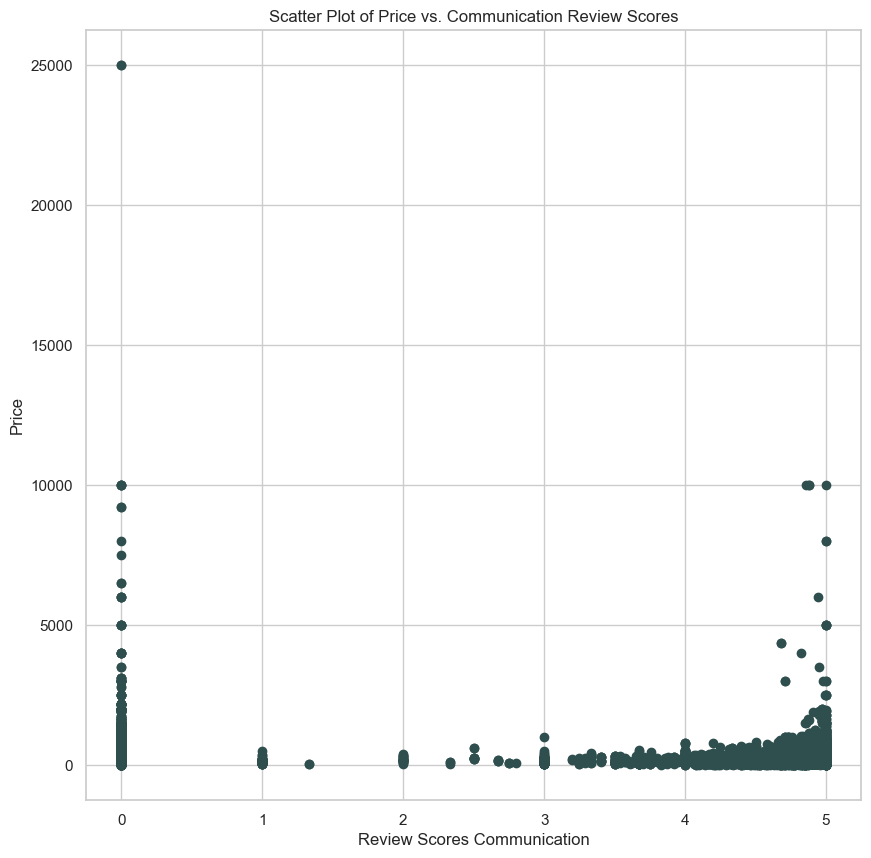

In [107]:
figure = plt.figure(figsize=(10, 10))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(all_listings_review_scores_communication, all_listings.price, marker="o", color="darkslategray")

axes.set_ylabel("Price")
axes.set_xlabel("Review Scores Communication")
axes.set_title("Scatter Plot of Price vs. Communication Review Scores")

plt.show()
plt.close()

## Price v. review_scores_location

In [108]:
all_listings_review_scores_location = all_listings.review_scores_location.fillna(0)

In [109]:
print("r   = ", stats.pearsonr(all_listings.price, all_listings_review_scores_location)[0])
print("rho = ", stats.spearmanr(all_listings.price, all_listings_review_scores_location)[0])

r   =  -0.1223089920355543
rho =  -0.004260113499384281


Pearson's correlation coefficient, 𝑟 , is only -0.12 which indicates a weak inverse relationship. Spearman's is interesting at -0.004 which indicates a very weak inverse monotonic relationship.

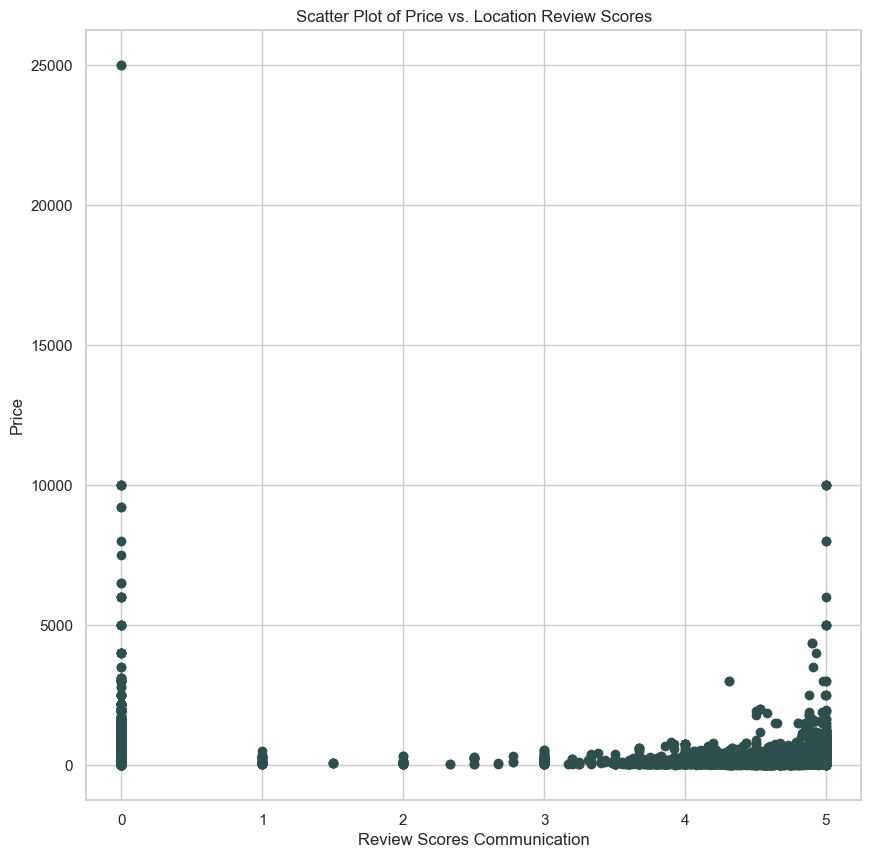

In [110]:
figure = plt.figure(figsize=(10, 10))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(all_listings_review_scores_location, all_listings.price, marker="o", color="darkslategray")

axes.set_ylabel("Price")
axes.set_xlabel("Review Scores Communication")
axes.set_title("Scatter Plot of Price vs. Location Review Scores")

plt.show()
plt.close()

## Price v. review_scores_value

In [111]:
all_listings_review_scores_value = all_listings.review_scores_value.fillna(0)

In [112]:
print("r   = ", stats.pearsonr(all_listings.price, all_listings_review_scores_value)[0])
print("rho = ", stats.spearmanr(all_listings.price, all_listings_review_scores_value)[0])

r   =  -0.12755198598554018
rho =  -0.14151081665715007


Pearson's correlation coefficient, 𝑟 , is only -0.13 which indicates a weak inverse relationship. Spearman's is interesting at -0.14 which indicates a very weak inverse monotonic relationship.

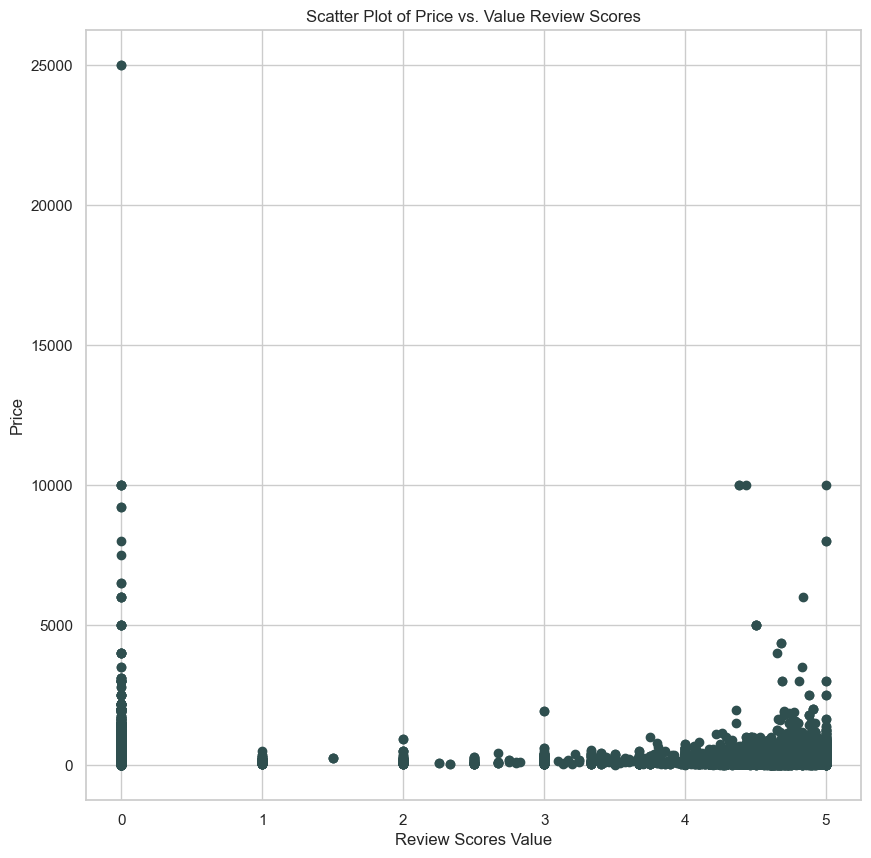

In [113]:
figure = plt.figure(figsize=(10, 10))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(all_listings_review_scores_value, all_listings.price, marker="o", color="darkslategray")

axes.set_ylabel("Price")
axes.set_xlabel("Review Scores Value")
axes.set_title("Scatter Plot of Price vs. Value Review Scores")

plt.show()
plt.close()

## Price v. number_of_reviews

In [114]:
all_listings_number_of_reviews = all_listings.number_of_reviews.fillna(0)

In [115]:
print("r   = ", stats.pearsonr(all_listings.price, all_listings_number_of_reviews)[0])
print("rho = ", stats.spearmanr(all_listings.price, all_listings_number_of_reviews)[0])

r   =  -0.06413653660937203
rho =  -0.14049401157230187


Pearson's correlation coefficient, 𝑟 , is only -0.06 which indicates a weak inverse relationship. Spearman's is interesting at -0.14 which indicates a very weak inverse monotonic relationship.

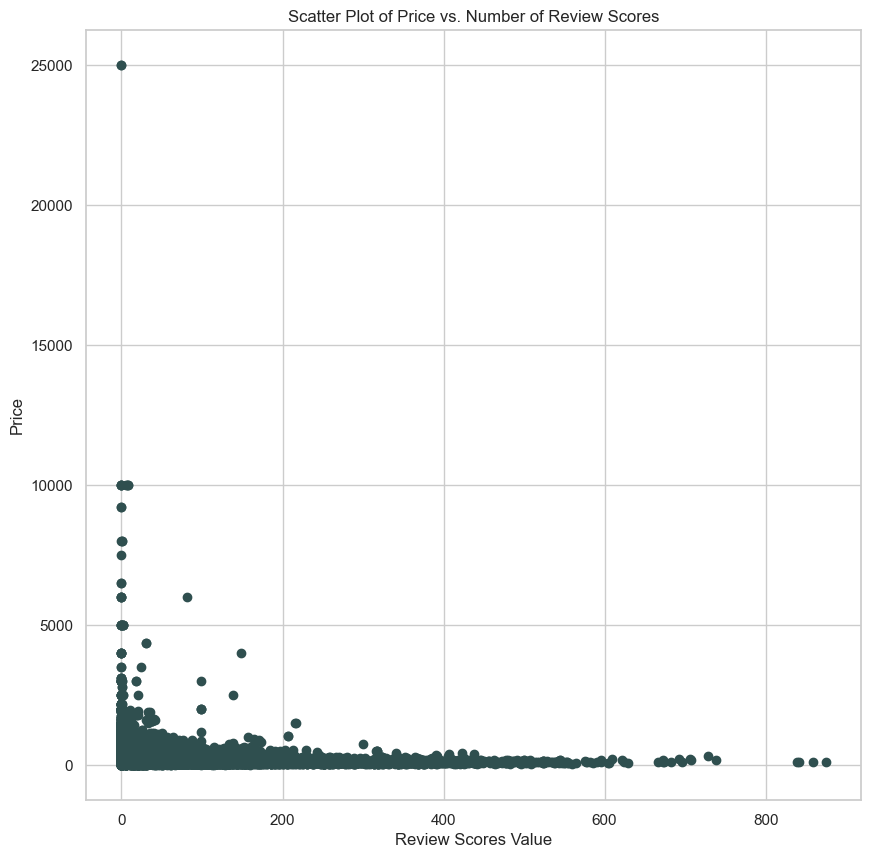

In [116]:
figure = plt.figure(figsize=(10, 10))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(all_listings_number_of_reviews, all_listings.price, marker="o", color="darkslategray")

axes.set_ylabel("Price")
axes.set_xlabel("Review Scores Value")
axes.set_title("Scatter Plot of Price vs. Number of Review Scores")

plt.show()
plt.close()

## Price v. number_of_reviews_l30d

In [117]:
all_listings_number_of_reviews_l30d = all_listings.number_of_reviews_l30d.fillna(0)

In [118]:
print("r   = ", stats.pearsonr(all_listings.price, all_listings_number_of_reviews_l30d)[0])
print("rho = ", stats.spearmanr(all_listings.price, all_listings_number_of_reviews_l30d)[0])

r   =  -0.0440713028233571
rho =  -0.0009861957153497168


Pearson's correlation coefficient, 𝑟 , is only -0.044 which indicates an extremely weak inverse relationship. Spearman's is interesting at -0.0009 which indicates there is not relationship. 

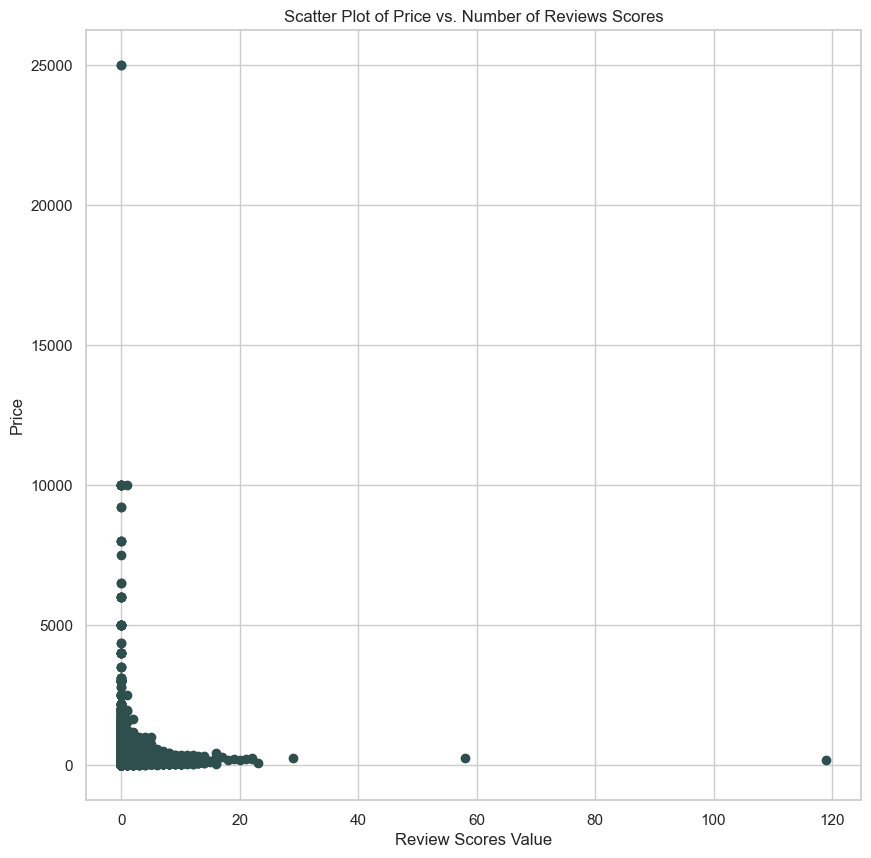

In [119]:
figure = plt.figure(figsize=(10, 10))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(all_listings_number_of_reviews_l30d, all_listings.price, marker="o", color="darkslategray")

axes.set_ylabel("Price")
axes.set_xlabel("Review Scores Value")
axes.set_title("Scatter Plot of Price vs. Number of Reviews Scores")

plt.show()
plt.close()

## Price v. reviews_per_month

In [120]:
all_listings_reviews_per_month = all_listings.reviews_per_month.fillna(0)

In [121]:
print("r   = ", stats.pearsonr(all_listings.price, all_listings_reviews_per_month)[0])
print("rho = ", stats.spearmanr(all_listings.price, all_listings_reviews_per_month)[0])

r   =  -0.06209532514038114
rho =  -0.09613667136252176


Pearson's correlation coefficient, 𝑟 , is only -0.062 which indicates an extremely weak inverse relationship. Spearman's is interesting at -0.096 which indicates there relationship.

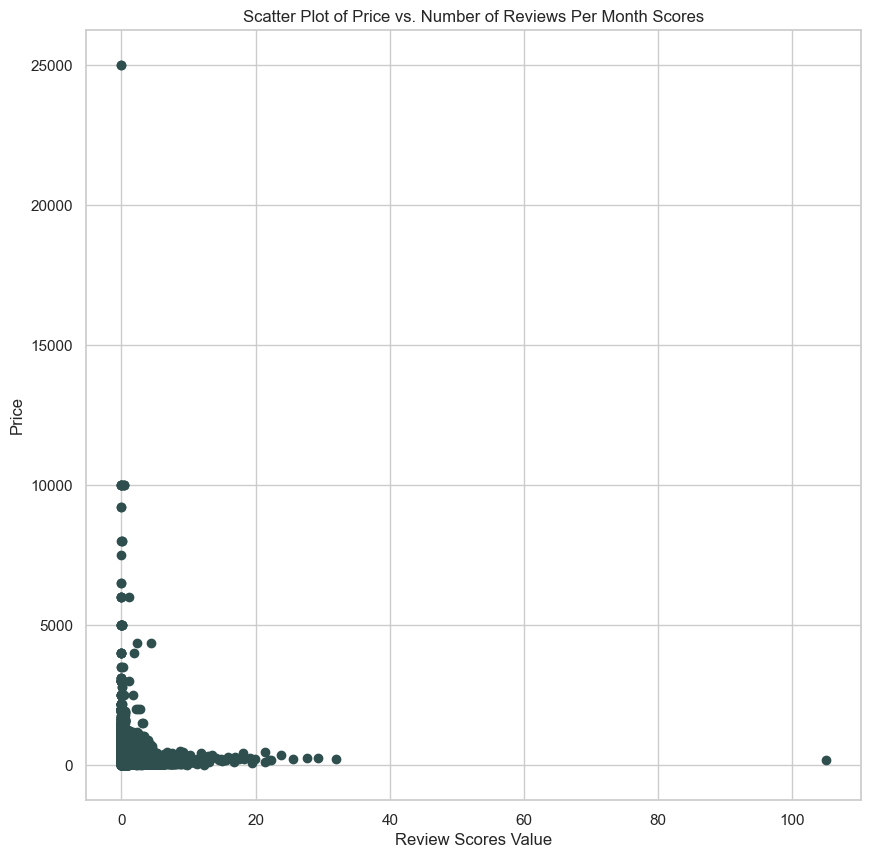

In [122]:
figure = plt.figure(figsize=(10, 10))

axes = figure.add_subplot(1, 1, 1)
axes.scatter(all_listings_reviews_per_month, all_listings.price, marker="o", color="darkslategray")

axes.set_ylabel("Price")
axes.set_xlabel("Review Scores Value")
axes.set_title("Scatter Plot of Price vs. Number of Reviews Per Month Scores")

plt.show()
plt.close()